Neural Style Transfer 🎨 uses deep learning to blend the content of one image with the artistic style of another, creating a unique and visually stunning artwork. 🖼️ This project demonstrates the power of convolutional neural networks to transform ordinary photos into masterpieces inspired by famous artists. 🌟

**1-Import Libraries:**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


**2-Load and Preprocess Image**

In [2]:
def load_and_process_image(image_path, max_dim=512):
    img = load_img(image_path)
    img = img_to_array(img)
    img = tf.image.resize(img, (max_dim, max_dim), preserve_aspect_ratio=True)
    img = img[tf.newaxis, :]  # Add batch dimension
    img = preprocess_input(img)
    return img

image_path = '/content/farog pic.jpg'

content_image = load_and_process_image(image_path)
style_image = load_and_process_image(image_path)


**3-Define the VGG19 Model**

In [3]:
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    output_layers = style_layers + content_layers
    model_outputs = [vgg.get_layer(name).output for name in output_layers]
    model = Model([vgg.input], model_outputs)
    return model, style_layers, content_layers

model, style_layers, content_layers = get_model()


80134624/80134624 [==============================] - 4s 0us/step


**4-Compute Content and Style Representation**

In [4]:
def get_feature_representations(model, content_image, style_image):
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]
    return style_features, content_features

style_features, content_features = get_feature_representations(model, content_image, style_image)


**5-Define Loss Function**

In [5]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]
    style_score = 0
    content_score = 0
    weight_per_style_layer = 1.0 / float(len(style_layers))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style, target_style)
    weight_per_content_layer = 1.0 / float(len(content_layers))
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content, target_content)
    style_score *= style_weight
    content_score *= content_weight
    loss = style_score + content_score
    return loss, style_score, content_score


**6-Optimization**

In [6]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(image_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model, style_layers, content_layers = get_model()
    for layer in model.layers:
        layer.trainable = False
    content_image = load_and_process_image(image_path)
    style_image = load_and_process_image(image_path)
    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)
    iter_count = 1
    best_loss, best_img = float('inf'), None
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()
        if i % 100 == 0:
            print(f"Iteration: {i}")
            print(f"Total loss: {loss}, Style loss: {style_score}, Content loss: {content_score}")
    return best_img, best_loss


**7-Run the Style Transfer**

Iteration: 0
Total loss: 0.0, Style loss: 0.0, Content loss: 0.0
Iteration: 100
Total loss: 696625.1875, Style loss: 495170.9375, Content loss: 201454.234375
Iteration: 200
Total loss: 271009.34375, Style loss: 173379.34375, Content loss: 97629.9921875
Iteration: 300
Total loss: 128232.984375, Style loss: 74907.09375, Content loss: 53325.89453125
Iteration: 400
Total loss: 68161.21875, Style loss: 37356.7578125, Content loss: 30804.46484375
Iteration: 500
Total loss: 41721.4765625, Style loss: 22689.87890625, Content loss: 19031.59765625
Iteration: 600
Total loss: 28969.5625, Style loss: 15894.0986328125, Content loss: 13075.46484375
Iteration: 700
Total loss: 21406.89453125, Style loss: 11985.5068359375, Content loss: 9421.388671875
Iteration: 800
Total loss: 16586.53125, Style loss: 9433.7568359375, Content loss: 7152.77392578125
Iteration: 900
Total loss: 13501.81640625, Style loss: 7740.7568359375, Content loss: 5761.05908203125


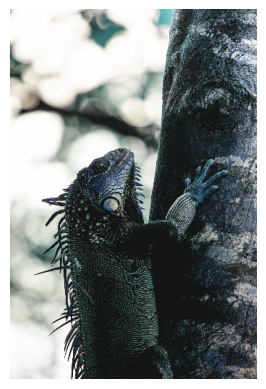

In [7]:
best_img, best_loss = run_style_transfer(image_path, num_iterations=1000)
best_img = best_img[0]  # This line can be problematic if best_img is not 4-dimensional
best_img = np.clip(best_img + np.array([103.939, 116.779, 123.68]), 0, 255).astype('uint8')

plt.imshow(best_img)
plt.axis('off')
plt.show()
